# 降圧型 DC-DC コンバータの RNN を使ったシミュレータ実験

$$i_L(t + \Delta t) = i_L(t) + \frac{\Delta t}{L} (v_a - v_o)$$

$$v_C(t + \Delta t) = v_C(t) + \frac{\Delta t}{C_o} \left( i_L - \frac{v_o}{R_o} \right)$$

1. DC-DC コンバータの波形を仮で作成
2. ノイズを乗せる
3. 学習モデルを作成し、回路パラメータの推論を行う


In [22]:
# 各種のインポート
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [23]:
# ============================
# 1. 学習用データ生成（過渡応答を含む）
# ============================

# 真の回路パラメータ
true_L = 100e-6  # インダクタ [H]
true_C = 47e-6  # コンデンサ [F]
true_R = 10.0  # 負荷抵抗 [Ω]

Vin = 12.0  # 入力電圧 [V]
dt = 1e-6  # タイムステップ [s]
Tsim = 0.005  # シミュレーション時間（過渡応答を含むよう長めに）
steps = int(Tsim / dt)

# PWM設定
f_sw = 100e3  # スイッチング周波数 [Hz]
duty = 0.5  # デューティ比
period = int(1 / f_sw / dt)

# スイッチング波形生成
va_np = np.zeros(steps)
for t in range(steps):
    if (t % period) < (period * duty):
        va_np[t] = Vin
    else:
        va_np[t] = 0.0

# 状態変数初期化（ゼロから開始して過渡応答を含める）
iL_np = np.zeros(steps)
vC_np = np.zeros(steps)
iL_np[0] = 0.0
vC_np[0] = 0.0

# オイラー法によるシミュレーション（真のパラメータ使用）
for t in range(steps - 1):
    # DCM対応
    v_a_eff = va_np[t]
    if va_np[t] == 0 and iL_np[t] <= 0:
        v_a_eff = vC_np[t]

    di = (dt / true_L) * (v_a_eff - vC_np[t])
    dv = (dt / true_C) * (iL_np[t] - vC_np[t] / true_R)

    iL_np[t + 1] = max(0, iL_np[t] + di)  # 電流は負にならない
    vC_np[t + 1] = vC_np[t] + dv

# PyTorchテンソル化
va = torch.tensor(va_np[:-1], dtype=torch.float32).unsqueeze(1)
iL = torch.tensor(iL_np, dtype=torch.float32)
vC = torch.tensor(vC_np, dtype=torch.float32)

# 状態ベクトル
h_seq = torch.stack([iL[:-1], vC[:-1]], dim=1)  # 現在の状態
h_target = torch.stack([iL[1:], vC[1:]], dim=1)  # 次時刻の状態

# シーケンスの長さ
N = len(va)
print(f"Generated {N} samples")
print(
    f"True parameters: L={true_L * 1e6:.1f}µH, C={true_C * 1e6:.1f}µF, R={true_R:.1f}Ω"
)

Generated 4999 samples
True parameters: L=100.0µH, C=47.0µF, R=10.0Ω


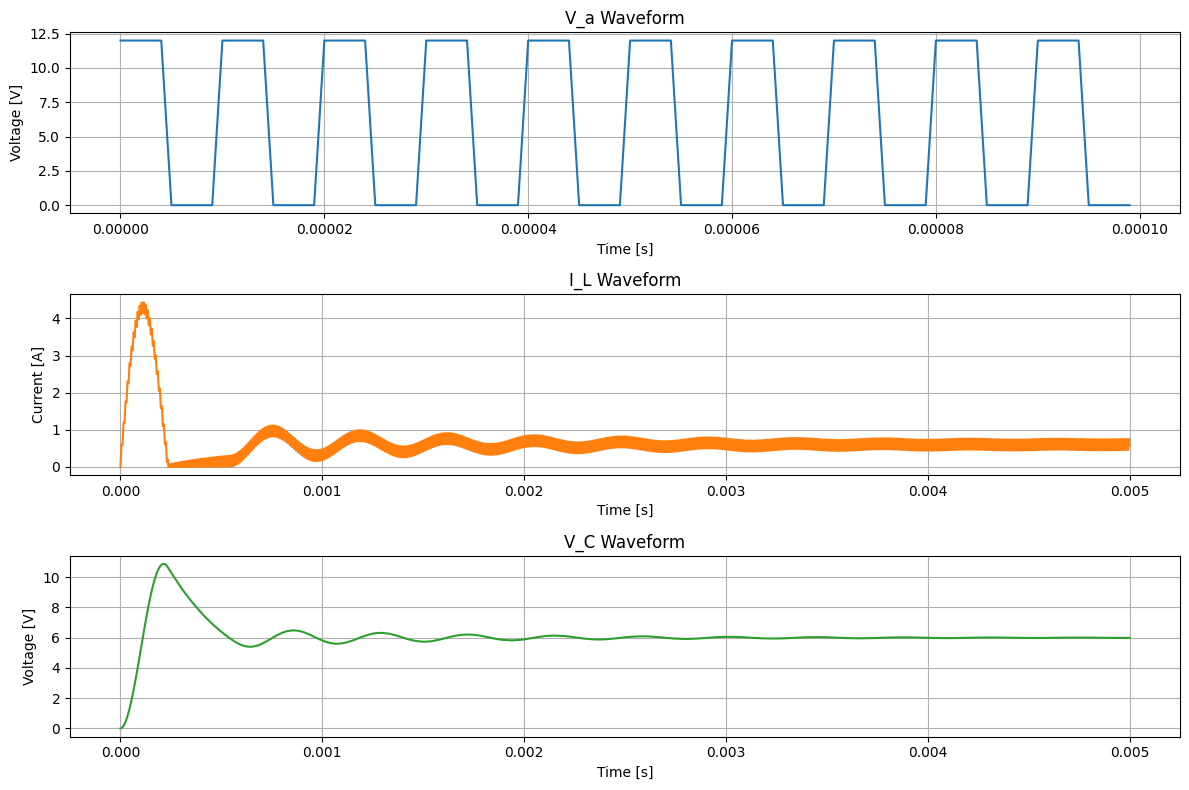

In [24]:
# 独立変数（時間）の生成
time = np.arange(0, steps * dt, dt)

# 描画
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(time[:100], va_np[:100], label="va(t)")
axs[0].set_title("V_a Waveform")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Voltage [V]")
axs[0].grid(True)

axs[1].plot(time[:-1], iL_np[:-1], label="iL(t)", color="tab:orange")
axs[1].set_title("I_L Waveform")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Current [A]")
axs[1].grid(True)

axs[2].plot(time[:-1], vC_np[:-1], label="vC(t)", color="tab:green")
axs[2].set_title("V_C Waveform")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Voltage [V]")
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [25]:
# ============================
# 2. BuckConverterCell 定義
# ============================
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,  # 初期値
        C_init: float = 100e-6,  # 初期値
        R_init: float = 8.0,  # 初期値
    ) -> None:
        super().__init__()
        self.dt = dt
        # パラメータを対数空間で学習（正の値を保証）
        # self.log_L = nn.Parameter(torch.tensor(L_init))
        # self.log_C = nn.Parameter(torch.tensor(C_init))
        # self.log_R = nn.Parameter(torch.tensor(R_init))
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(self, h: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        i_L, v_C = h[:, 0], h[:, 1]
        v_a = x[:, 0]

        # パラメータを指数関数で変換（正の値を保証）
        # L = self.log_L
        # C = self.log_C
        # R = self.log_R
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # --- DCM対応 (idx) ---------------------------------------------------
        # スイッチOFF(va=0) かつ インダクタ電流がゼロ以下のとき、
        # フリーホイールダイオードがOFFになるため va = vC とする
        idx = (v_a == 0) & (i_L <= 0)
        if idx.any():
            v_a = v_a.clone()
            v_a[idx] = v_C[idx]
        # -------------------------------------------------------------------

        di = (self.dt / L) * (v_a - v_C)
        dv = (self.dt / C) * (i_L - v_C / R)

        i_L_next = i_L + di
        i_L_next = torch.relu(i_L_next)
        v_C_next = v_C + dv

        return torch.stack([i_L_next, v_C_next], dim=1)

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
        }


# ============================
# 3. モデルと最適化設定
# ============================
model = BuckConverterCell(dt=1e-6)
optimizer = optim.Adam(model.parameters(), lr=5e-4)  # 学習率を調整
loss_fn = nn.MSELoss()

# ============================
# 4. 学習ループ
# ============================
epochs = 3000
loss_history = []
param_history = {"L": [], "C": [], "R": []}  # パラメータの履歴を保存

for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred = model(h_seq, va)
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])

    if epoch % 300 == 0:
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={true_L * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={true_C * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={true_R:.1f})"
        )

print(
    f"Epoch {epoch}: Loss={loss.item():.6e}  "
    f"L={params['L'] * 1e6:.1f}µH (true={true_L * 1e6:.1f})  "
    f"C={params['C'] * 1e6:.1f}µF (true={true_C * 1e6:.1f})  "
    f"R={params['R']:.2f}Ω (true={true_R:.1f})"
)


# ============================
# 5. 学習後のパラメータ
# ============================
print("\n=== Learned Parameters ===")
learned_params = model.get_params()
for key in ["L", "C", "R"]:
    true_val = {"L": true_L, "C": true_C, "R": true_R}[key]
    learned_val = learned_params[key]
    error = abs(learned_val - true_val) / true_val * 100

    if key in ["L", "C"]:
        unit = "H" if key == "L" else "F"
        print(
            f"{key}: True={true_val * 1e6:.1f}µ{unit}, "
            f"Learned={learned_val * 1e6:.1f}µ{unit}, "
            f"Error={error:.1f}%"
        )
    else:
        print(
            f"{key}: True={true_val:.1f}Ω, Learned={learned_val:.2f}Ω, "
            f"Error={error:.1f}%"
        )

# ============================
# 6. シミュレーション（再現波形生成）
# ============================
with torch.no_grad():
    h_sim = [h_seq[0].unsqueeze(0)]
    for t in range(1, N):
        h_next = model(h_sim[-1], va[t - 1].unsqueeze(0))
        h_sim.append(h_next)
    h_sim = torch.cat(h_sim, dim=0)

iL_sim = h_sim[:, 0].numpy()
vC_sim = h_sim[:, 1].numpy()

Epoch 0: Loss=4.732365e-04  L=199.9µH (true=100.0)  C=100.0µF (true=47.0)  R=8.00Ω (true=10.0)
Epoch 300: Loss=3.328671e-04  L=172.2µH (true=100.0)  C=85.9µF (true=47.0)  R=9.12Ω (true=10.0)
Epoch 600: Loss=2.057573e-04  L=149.1µH (true=100.0)  C=74.0µF (true=47.0)  R=9.88Ω (true=10.0)
Epoch 900: Loss=1.055999e-04  L=130.8µH (true=100.0)  C=64.5µF (true=47.0)  R=10.14Ω (true=10.0)
Epoch 1200: Loss=4.160957e-05  L=117.3µH (true=100.0)  C=57.3µF (true=47.0)  R=10.11Ω (true=10.0)
Epoch 1500: Loss=1.148673e-05  L=108.3µH (true=100.0)  C=52.3µF (true=47.0)  R=10.06Ω (true=10.0)
Epoch 1800: Loss=2.053267e-06  L=103.3µH (true=100.0)  C=49.3µF (true=47.0)  R=10.02Ω (true=10.0)
Epoch 2100: Loss=2.275580e-07  L=101.1µH (true=100.0)  C=47.8µF (true=47.0)  R=10.01Ω (true=10.0)
Epoch 2400: Loss=1.528432e-08  L=100.3µH (true=100.0)  C=47.2µF (true=47.0)  R=10.00Ω (true=10.0)
Epoch 2700: Loss=6.017447e-10  L=100.1µH (true=100.0)  C=47.1µF (true=47.0)  R=10.00Ω (true=10.0)
Epoch 2999: Loss=1.048892e-1

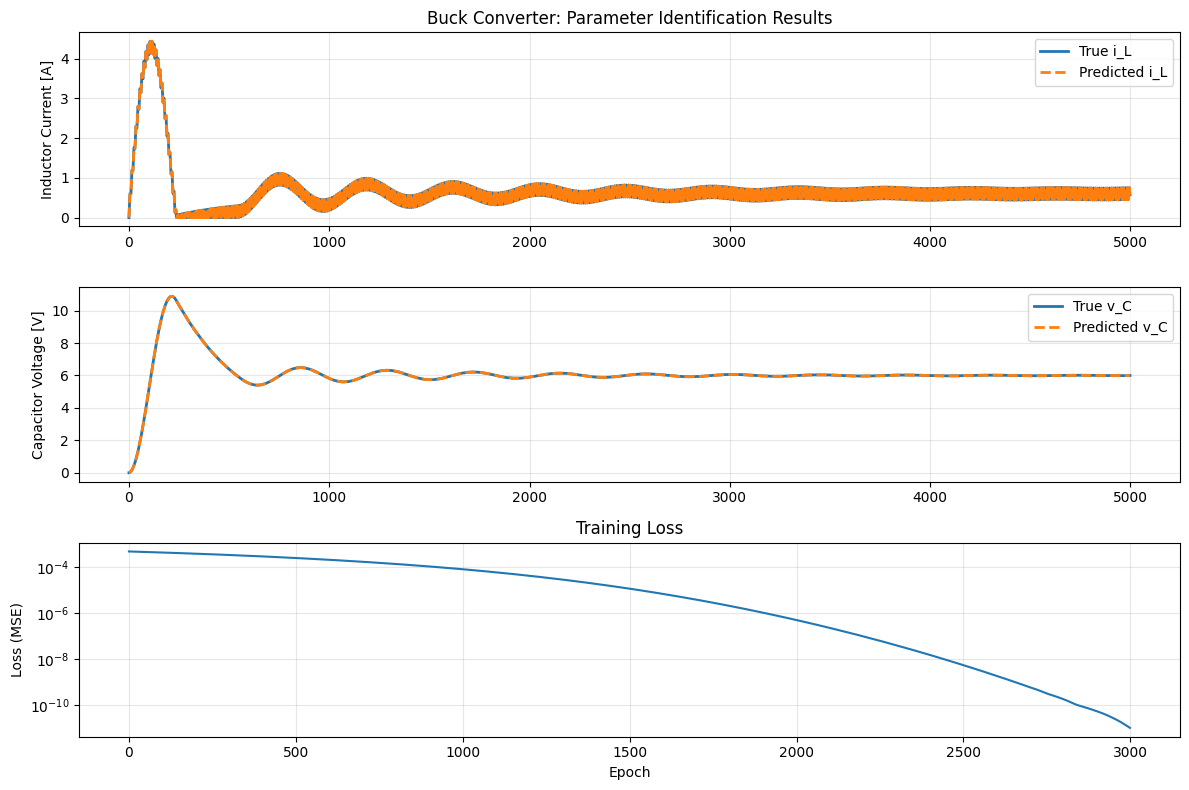

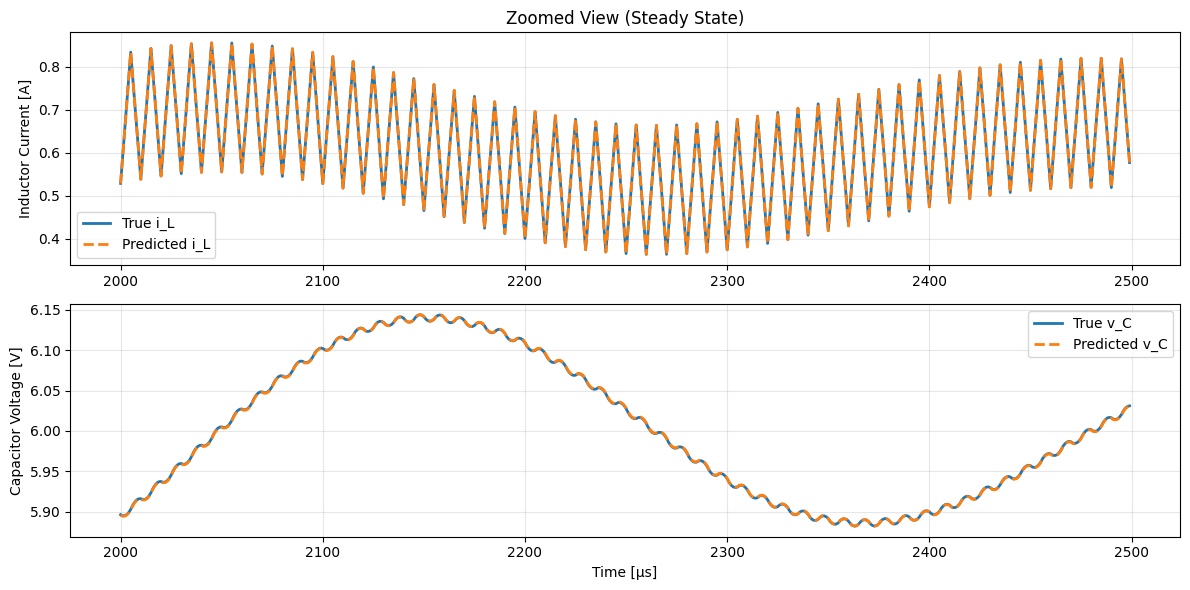

In [26]:
# ============================
# 7. 波形比較プロット
# ============================
time = np.arange(N) * dt * 1e6  # μs単位

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# インダクタ電流
axes[0].plot(time, iL[:-1], label="True i_L", linewidth=2)
axes[0].plot(time, iL_sim, "--", label="Predicted i_L", linewidth=2)
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results")

# キャパシタ電圧
axes[1].plot(time, vC[:-1], label="True v_C", linewidth=2)
axes[1].plot(time, vC_sim, "--", label="Predicted v_C", linewidth=2)
axes[1].set_ylabel("Capacitor Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴
axes[2].semilogy(loss_history)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training Loss")

plt.tight_layout()
plt.show()

# 一部区間の詳細表示
plt.figure(figsize=(12, 6))
start_idx = 2000
end_idx = 2500

plt.subplot(2, 1, 1)
plt.plot(time[start_idx:end_idx], iL[start_idx:end_idx], label="True i_L", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    iL_sim[start_idx:end_idx],
    "--",
    label="Predicted i_L",
    linewidth=2,
)
plt.ylabel("Inductor Current [A]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Zoomed View (Steady State)")

plt.subplot(2, 1, 2)
plt.plot(time[start_idx:end_idx], vC[start_idx:end_idx], label="True v_C", linewidth=2)
plt.plot(
    time[start_idx:end_idx],
    vC_sim[start_idx:end_idx],
    "--",
    label="Predicted v_C",
    linewidth=2,
)
plt.ylabel("Capacitor Voltage [V]")
plt.xlabel("Time [µs]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

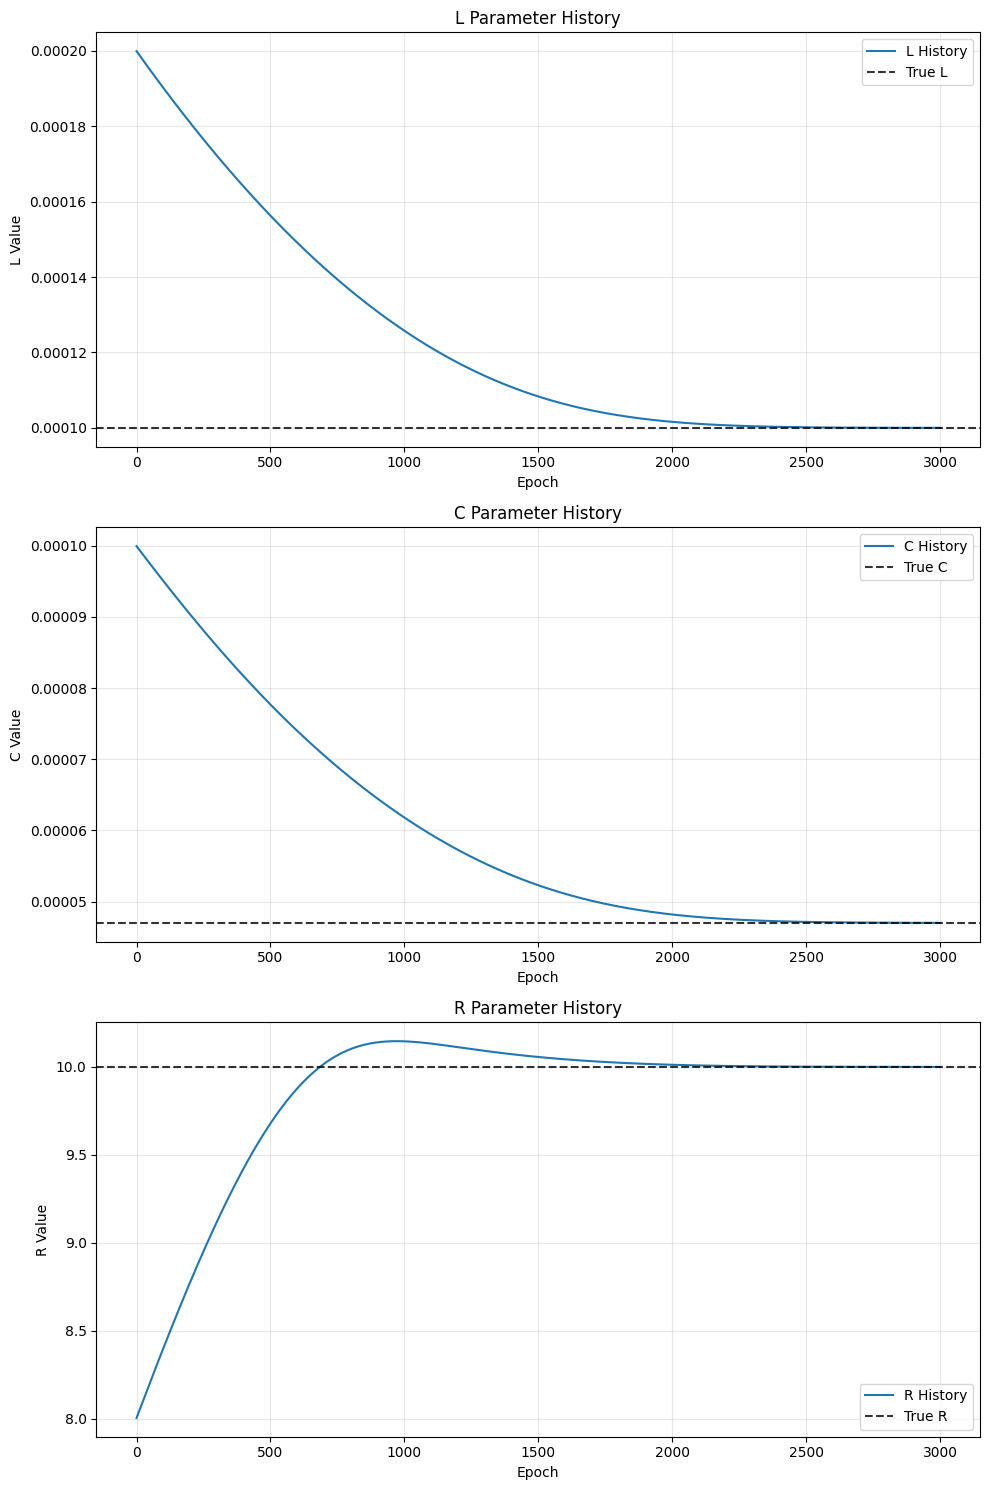

In [27]:
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=true_L, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=true_C, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=true_R, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()